In [1]:

from getpass import getpass

# Inserisci il tuo token quando richiesto
token = getpass('0df2f724e7d7cb4c6e9d947c386170db903578bf')

!git config --global user.email "simonaloc1@yahoo.it"
!git config --global user.name "simoLoc"

# Clona la tua repo usando il token
!git clone https://<simoLoc>:{token}@dagshub.com/<simoLoc>/<SE4AI_CelebA>.git

# Sposta il notebook nella cartella della repo se necessario


0df2f724e7d7cb4c6e9d947c386170db903578bf··········
/bin/bash: line 1: simoLoc: No such file or directory


In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import seaborn as sns
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# Unzip del dataset

In [ ]:
import zipfile
import os

def unzip_file(zip_filepath, extract_dir):
    """
    Unzips a zip file to a specified directory.

    Args:
        zip_filepath: The path to the zip file.
        extract_dir: The directory to extract the contents to.
    """
    try:
        with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Successfully unzipped '{zip_filepath}' to '{extract_dir}'")
    except FileNotFoundError:
        print(f"Error: File '{zip_filepath}' not found.")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_filepath}' is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


zip_file_path = "/content/drive/Shareddrives/ProgettoSE4AI/datasetCelebA.zip"
extraction_directory = "/content/drive/Shareddrives/ProgettoSE4AI/dataset"

unzip_file(zip_file_path, extraction_directory)


Successfully unzipped '/content/drive/Shareddrives/ProgettoSE4AI/datasetCelebA.zip' to '/content/drive/Shareddrives/ProgettoSE4AI/dataset'


# Analisi del dataset

In [ ]:
data_dir = '/content/drive/Shareddrives/ProgettoSE4AI/dataset/'

## Definizione dei metodi di plot




In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    # Ensure nGraphRow is an integer using floor division //
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = getattr(df, 'dataframeName', 'DataFrame')

    # 1) Drop colonne con qualunque NaN
    df_clean = df.dropna(axis=1)

    # 2) Tieni solo quelle con >1 valore unico
    cols = [c for c in df_clean.columns if df_clean[c].nunique() > 1]
    df_clean = df_clean[cols]

    if df_clean.shape[1] < 2:
        print(f'No correlation plots shown: only {df_clean.shape[1]} valid column(s)')
        return

    # 3) Calcola la correlazione
    corr = df_clean.corr()

    # 4) Crea la figura (senza num, facecolor, edgecolor: solo figsize)
    plt.figure(figsize=(graphWidth, graphWidth), dpi=80)

    # 5) Disegna la heatmap
    sns.heatmap(
        corr,
        annot=True,        # scrive i valori dentro le celle
        fmt=".2f",         # formattazione su due decimali
        cmap="coolwarm",   # palette diverging
        square=True,       # celle quadrate
        cbar_kws={"shrink": .8}  # barretta di colore più piccola
    )

    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    # 1) tieni solo le colonne numeriche
    df = df.select_dtypes(include=[np.number])

    # 2) rimuovi colonne con NaN
    df = df.dropna(axis=1)

    # 3) solo colonne con >1 valore unico
    df = df[[col for col in df.columns if df[col].nunique() > 1]]

    # 4) limitiamo a max 10 colonne per la KDE
    cols = list(df.columns)
    if len(cols) > 10:
        cols = cols[:10]
    df = df[cols]

    # 5) scatter‐matrix + KDE diagonale
    ax = pd.plotting.scatter_matrix(
        df,
        alpha=0.75,
        figsize=(plotSize, plotSize),
        diagonal='kde'
    )

    # 6) calcola la correlazione
    corrs = df.corr().values

    # 7) annota sopra il triangolo superiore
    #    np.triu_indices_from prende la shape di 'corrs'
    for i, j in zip(*np.triu_indices_from(corrs, k=1)):
        ax[i, j].annotate(
            f"Corr coef = {corrs[i, j]:.3f}",
            xy=(0.8, 0.2),
            xycoords='axes fraction',
            ha='center',
            va='center',
            size=textSize
        )

    plt.suptitle('Scatter and Density Plot', fontsize=textSize+2)
    plt.tight_layout()
    plt.show()

## Visualizzazione Plot dell'intero dataset

In [ ]:
attr_path = data_dir + 'list_attr_celeba.csv'
df_attr = pd.read_csv(attr_path, delimiter=',')
df_attr.dataframeName = 'list_attr_celeba.csv'
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
nRow, nCol = df_attr.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 202599 rows and 40 columns


In [ ]:
df_attr.head(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


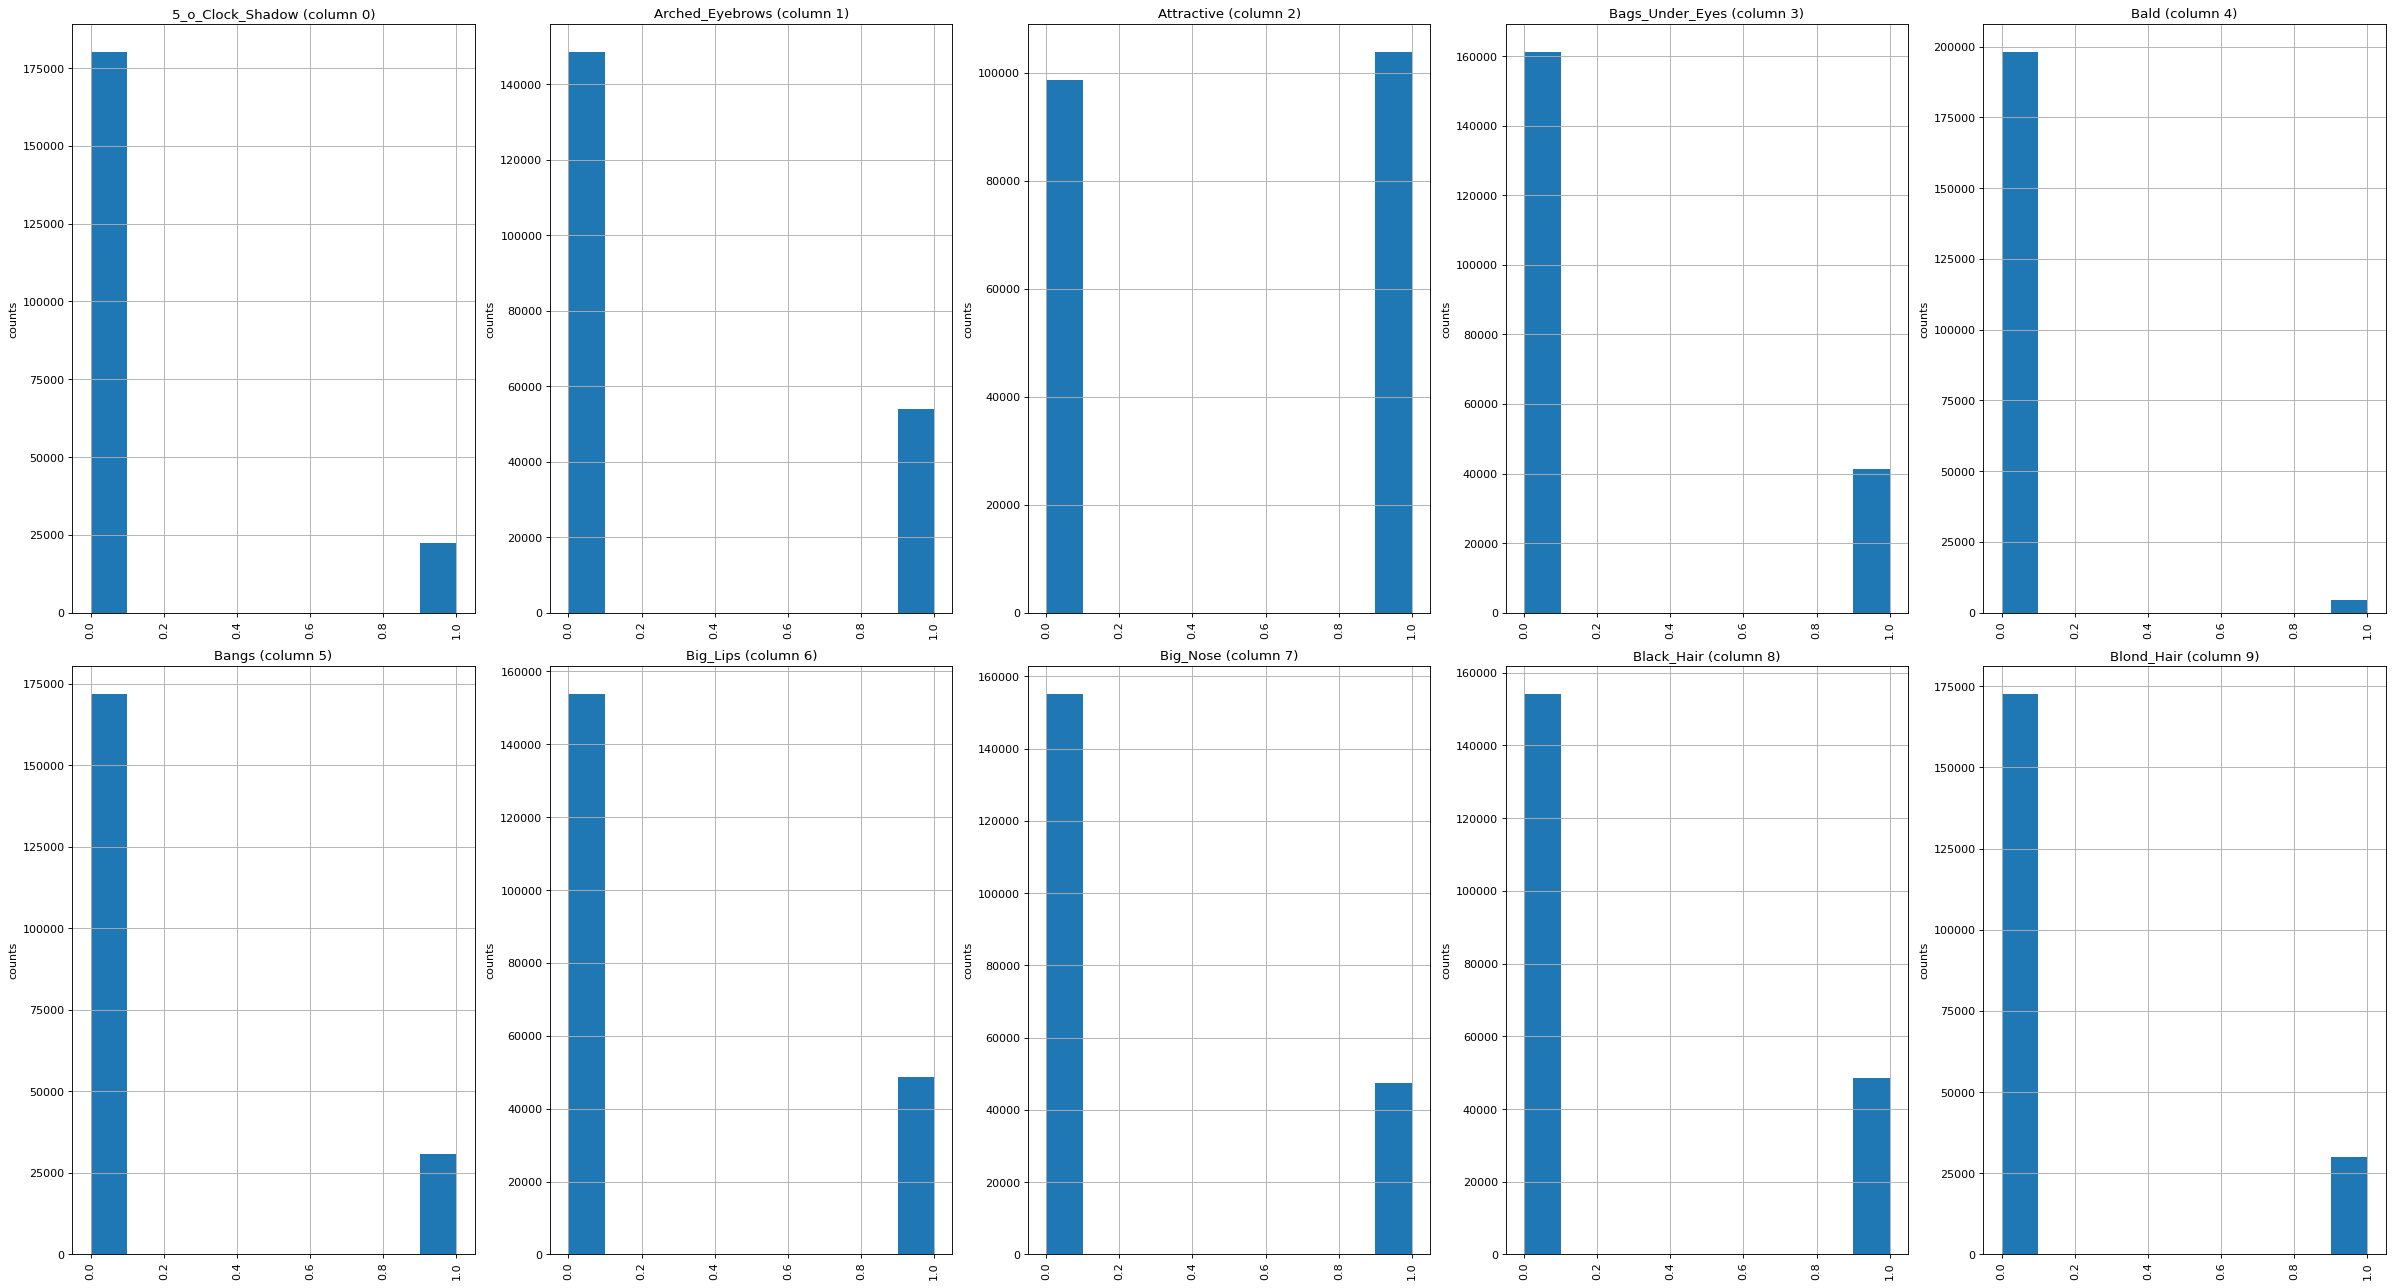

In [ ]:
plotPerColumnDistribution(df_attr, 10, 5)

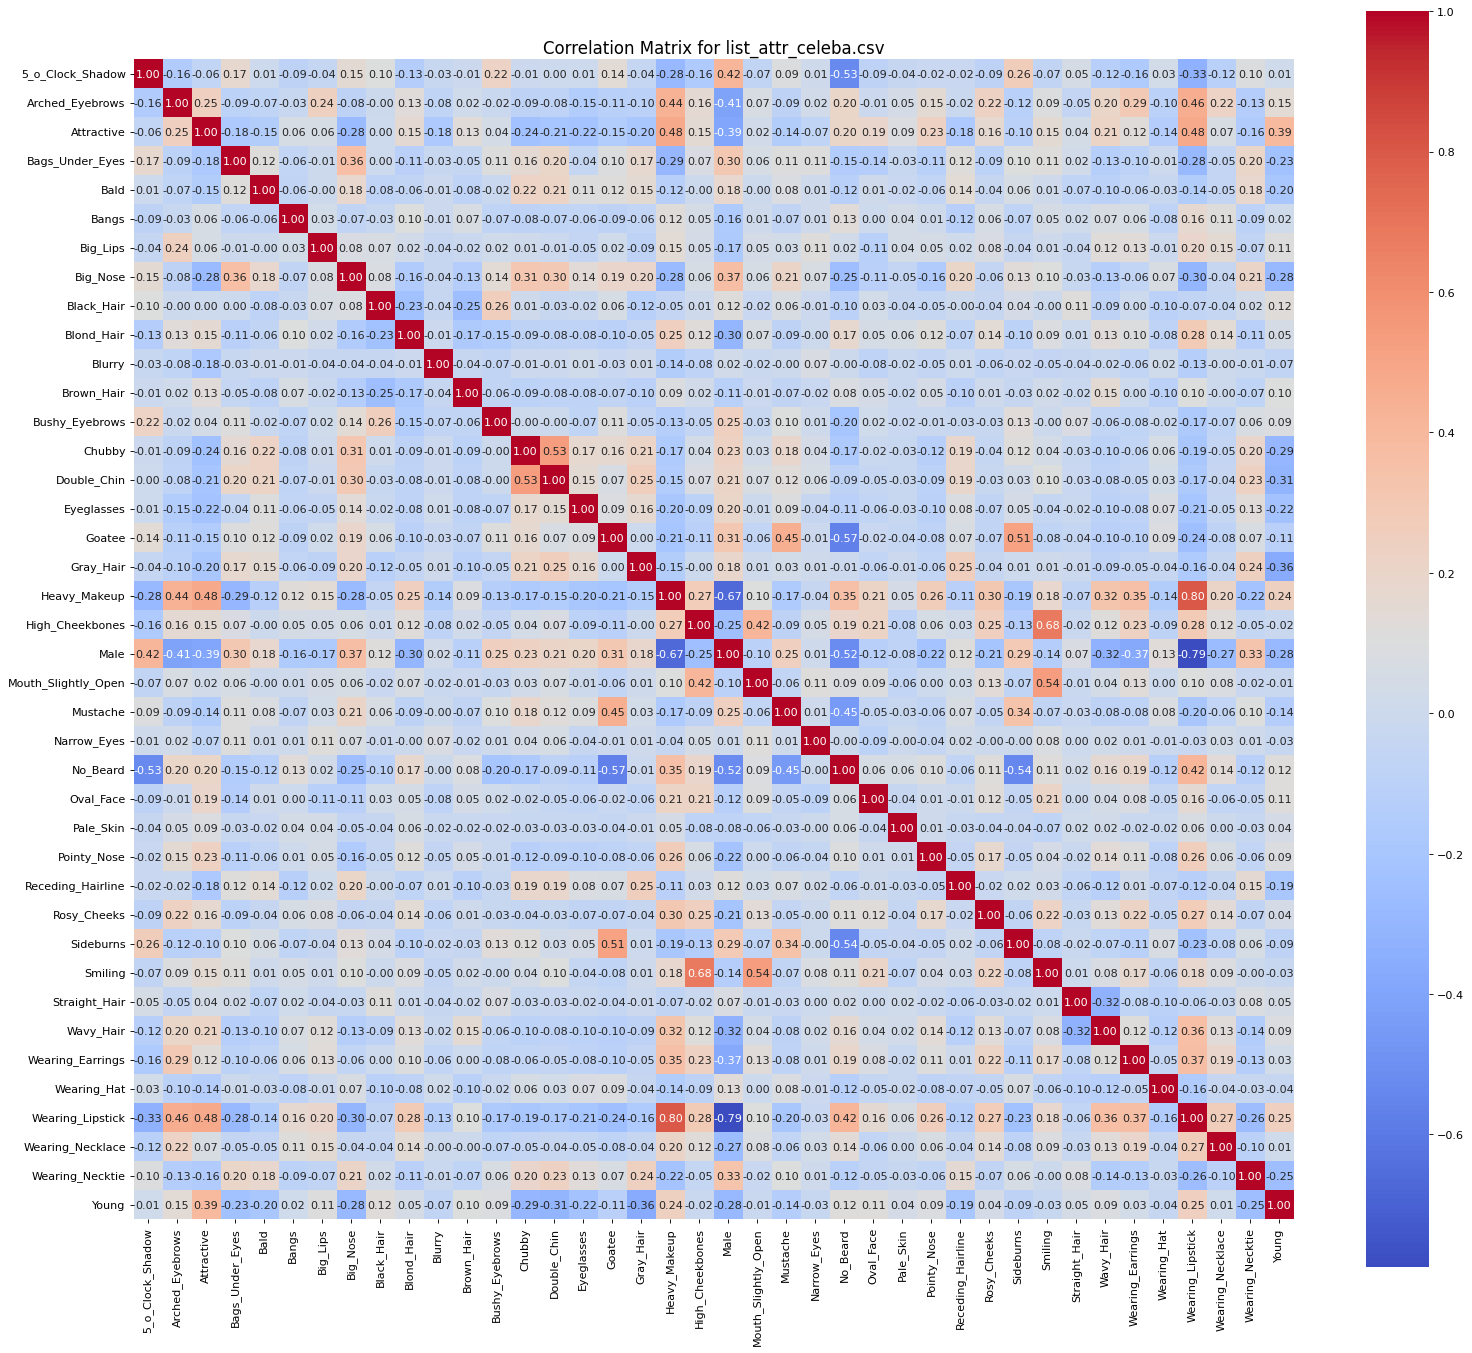

In [ ]:
plotCorrelationMatrix(df_attr, 20)

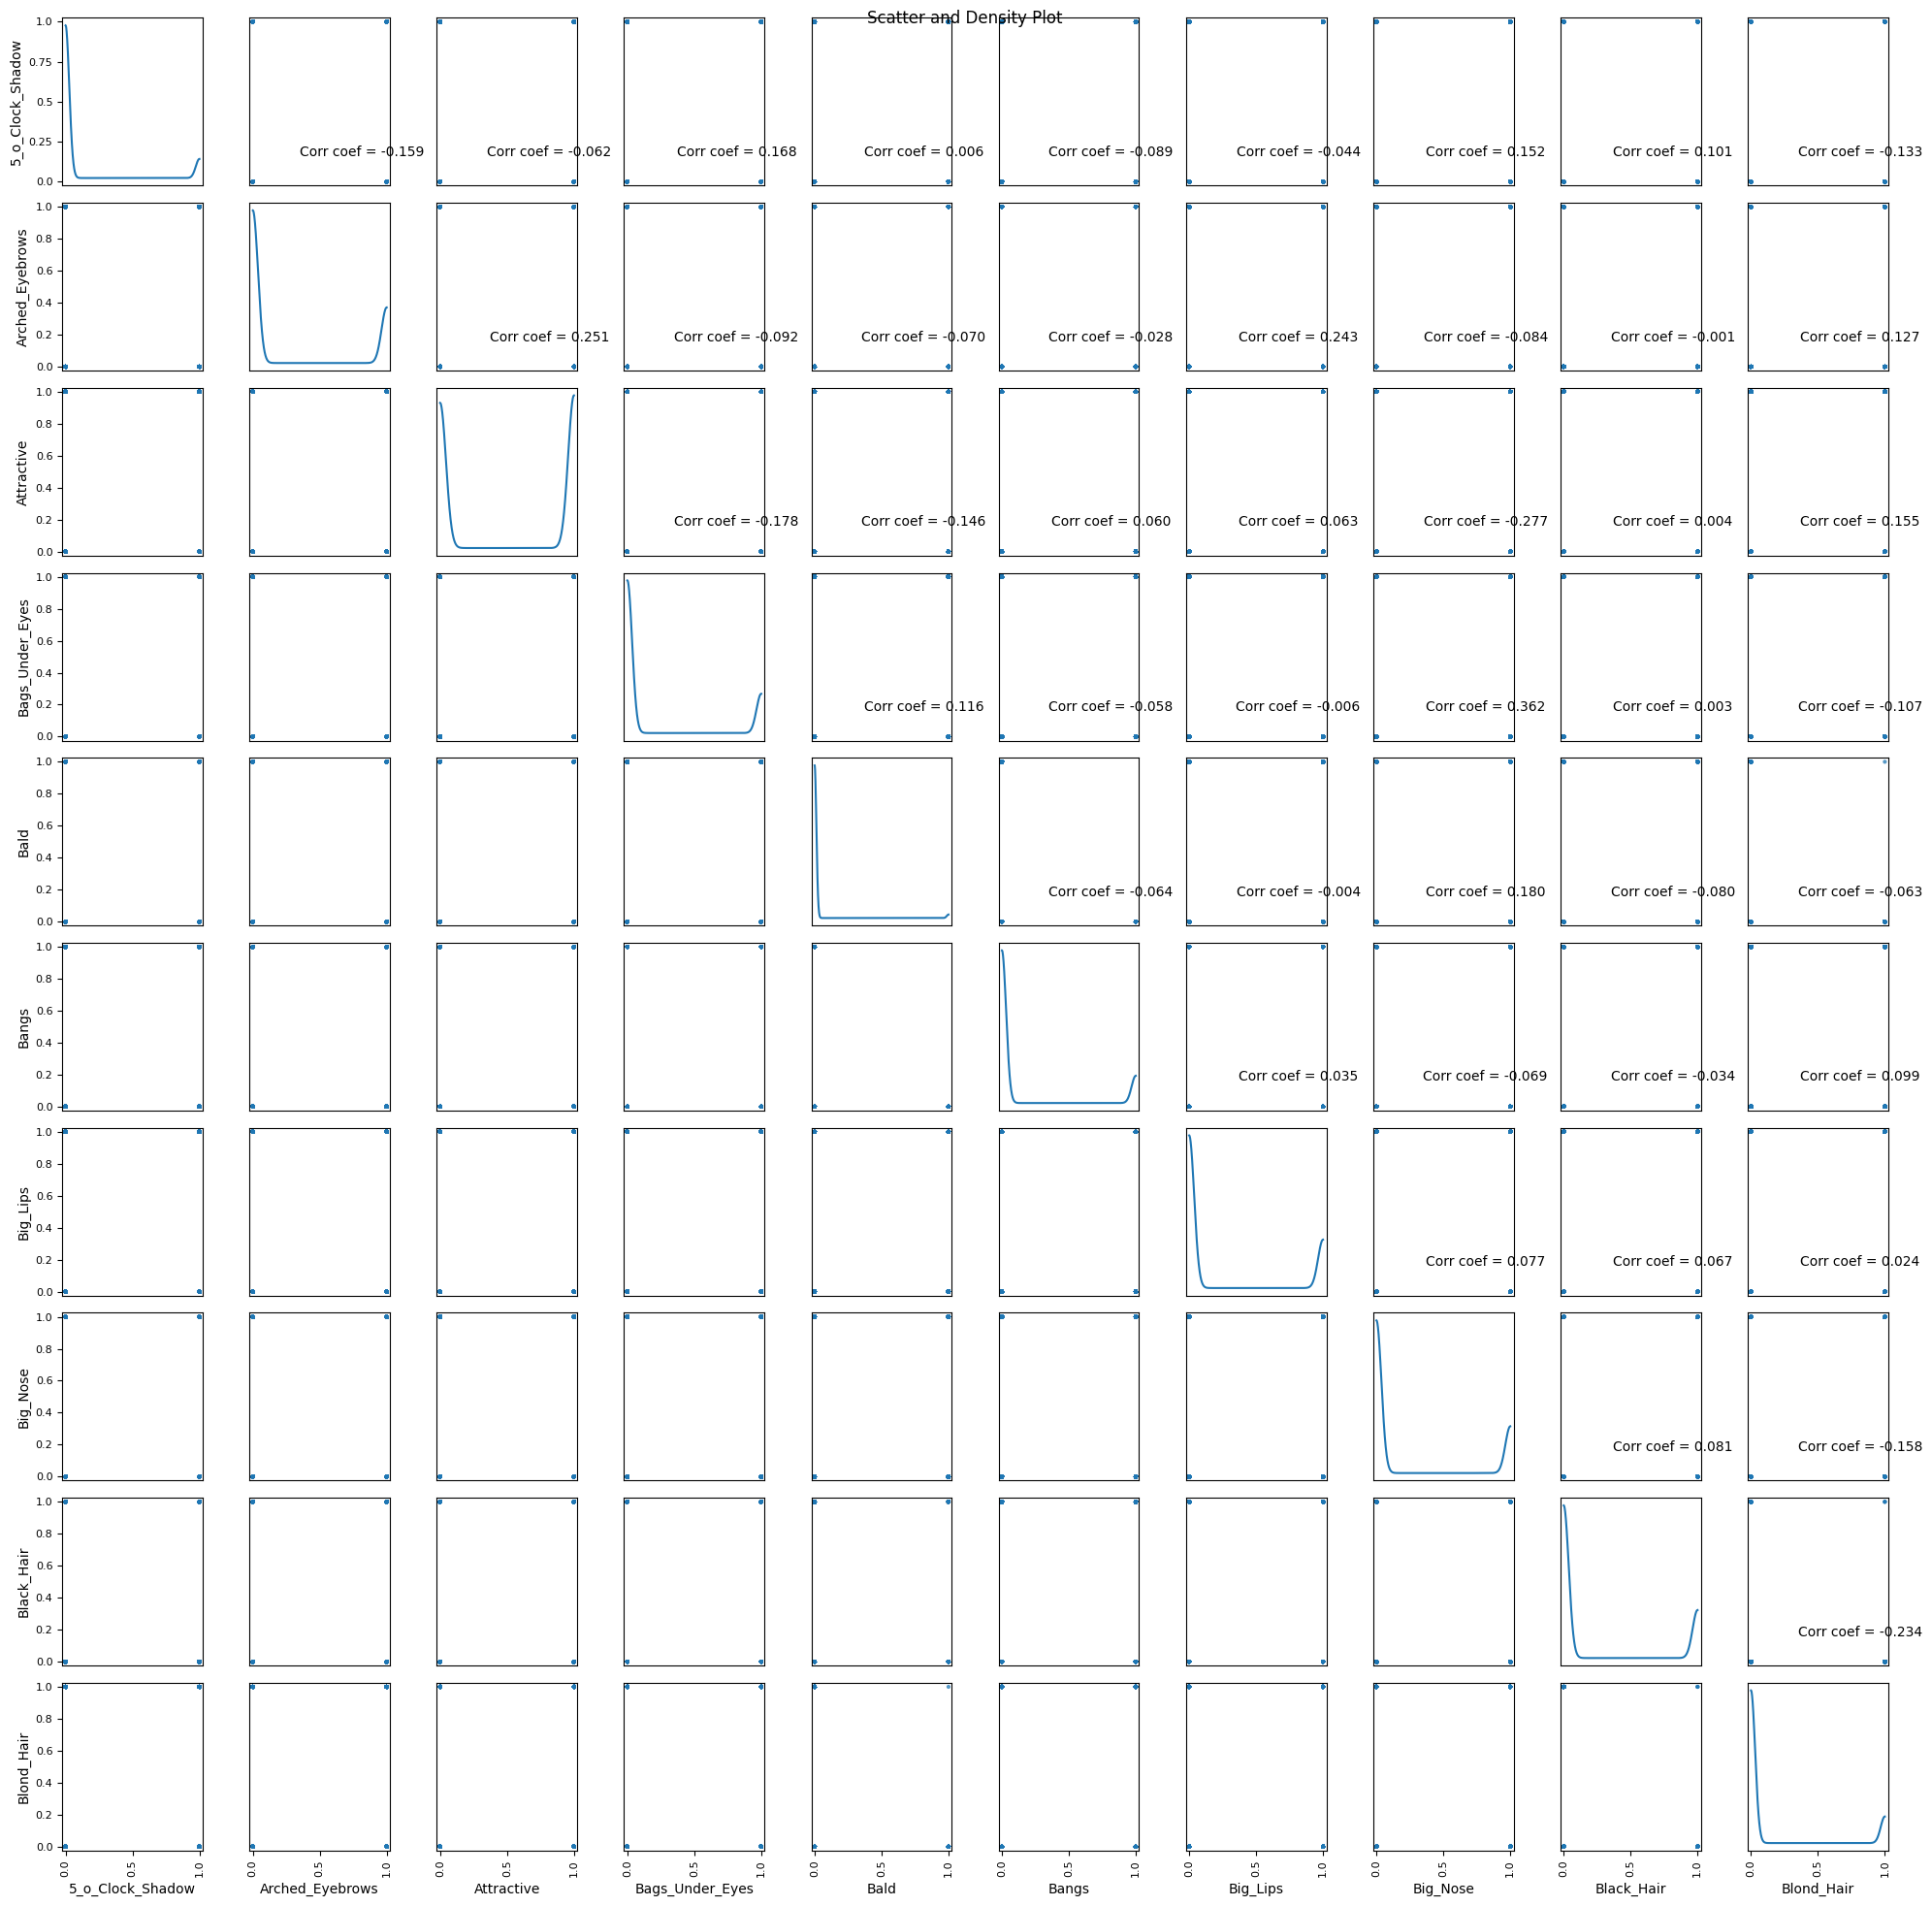

In [ ]:
plotScatterMatrix(df_attr, 20, 10)

In [ ]:
bbox_path = data_dir + 'list_bbox_celeba.csv'
df_bbox = pd.read_csv(bbox_path, delimiter=',')
df_bbox.dataframeName = 'list_bbox_celeba.csv'
nRow, nCol = df_bbox.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 202599 rows and 5 columns


In [ ]:
df_bbox.head(5)

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [ ]:
plotPerColumnDistribution(df_bbox, 10, 5)

<Figure size 2400x0 with 0 Axes>

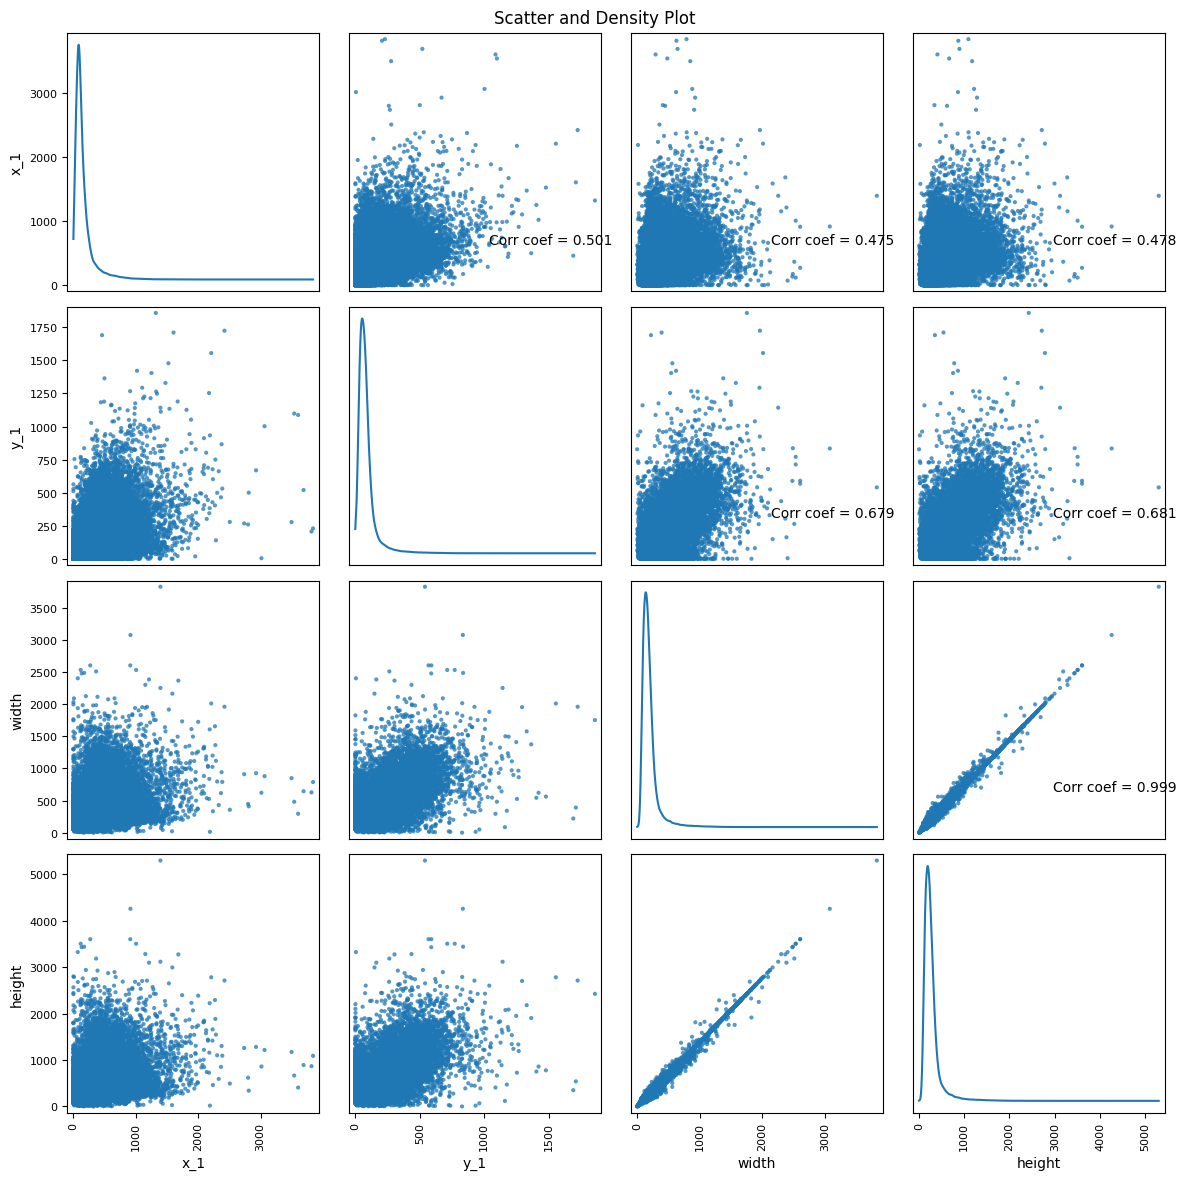

In [ ]:
plotScatterMatrix(df_bbox, 12, 10)

In [ ]:
list_partition_path = data_dir + 'list_eval_partition.csv'
df_list_partition = pd.read_csv(list_partition_path, delimiter=',')
df_list_partition.dataframeName = 'list_eval_partition.csv'
nRow, nCol = df_list_partition.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 202599 rows and 2 columns


In [ ]:
df_list_partition.head(5)

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


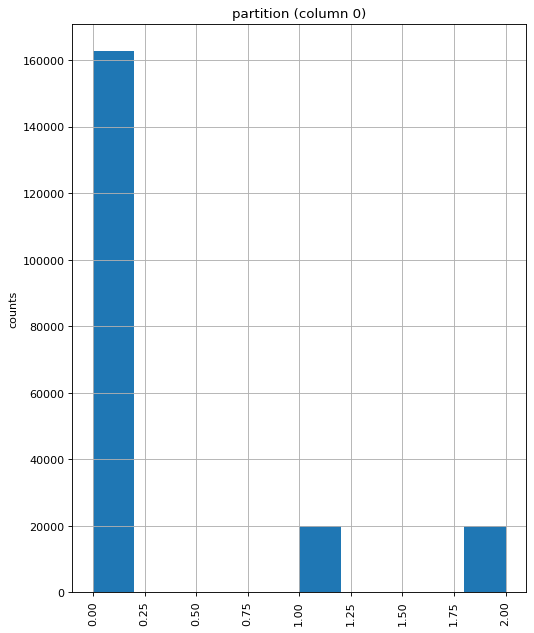

In [ ]:
plotPerColumnDistribution(df_list_partition, 10, 5)

In [ ]:
landmarks_path = data_dir + 'list_landmarks_align_celeba.csv'
df_landmarks = pd.read_csv(landmarks_path)
df_landmarks.set_index('image_id', inplace=True)
df_landmarks.dataframeName = 'list_landmarks_align_celeba.csv'
nRow, nCol = df_landmarks.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 202599 rows and 10 columns


In [ ]:
df_landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,69,109,106,113,77,142,73,152,108,154
000002.jpg,69,110,107,112,81,135,70,151,108,153
000003.jpg,76,112,104,106,108,128,74,156,98,158
000004.jpg,72,113,108,108,101,138,71,155,101,151
000005.jpg,66,114,112,112,86,119,71,147,104,150


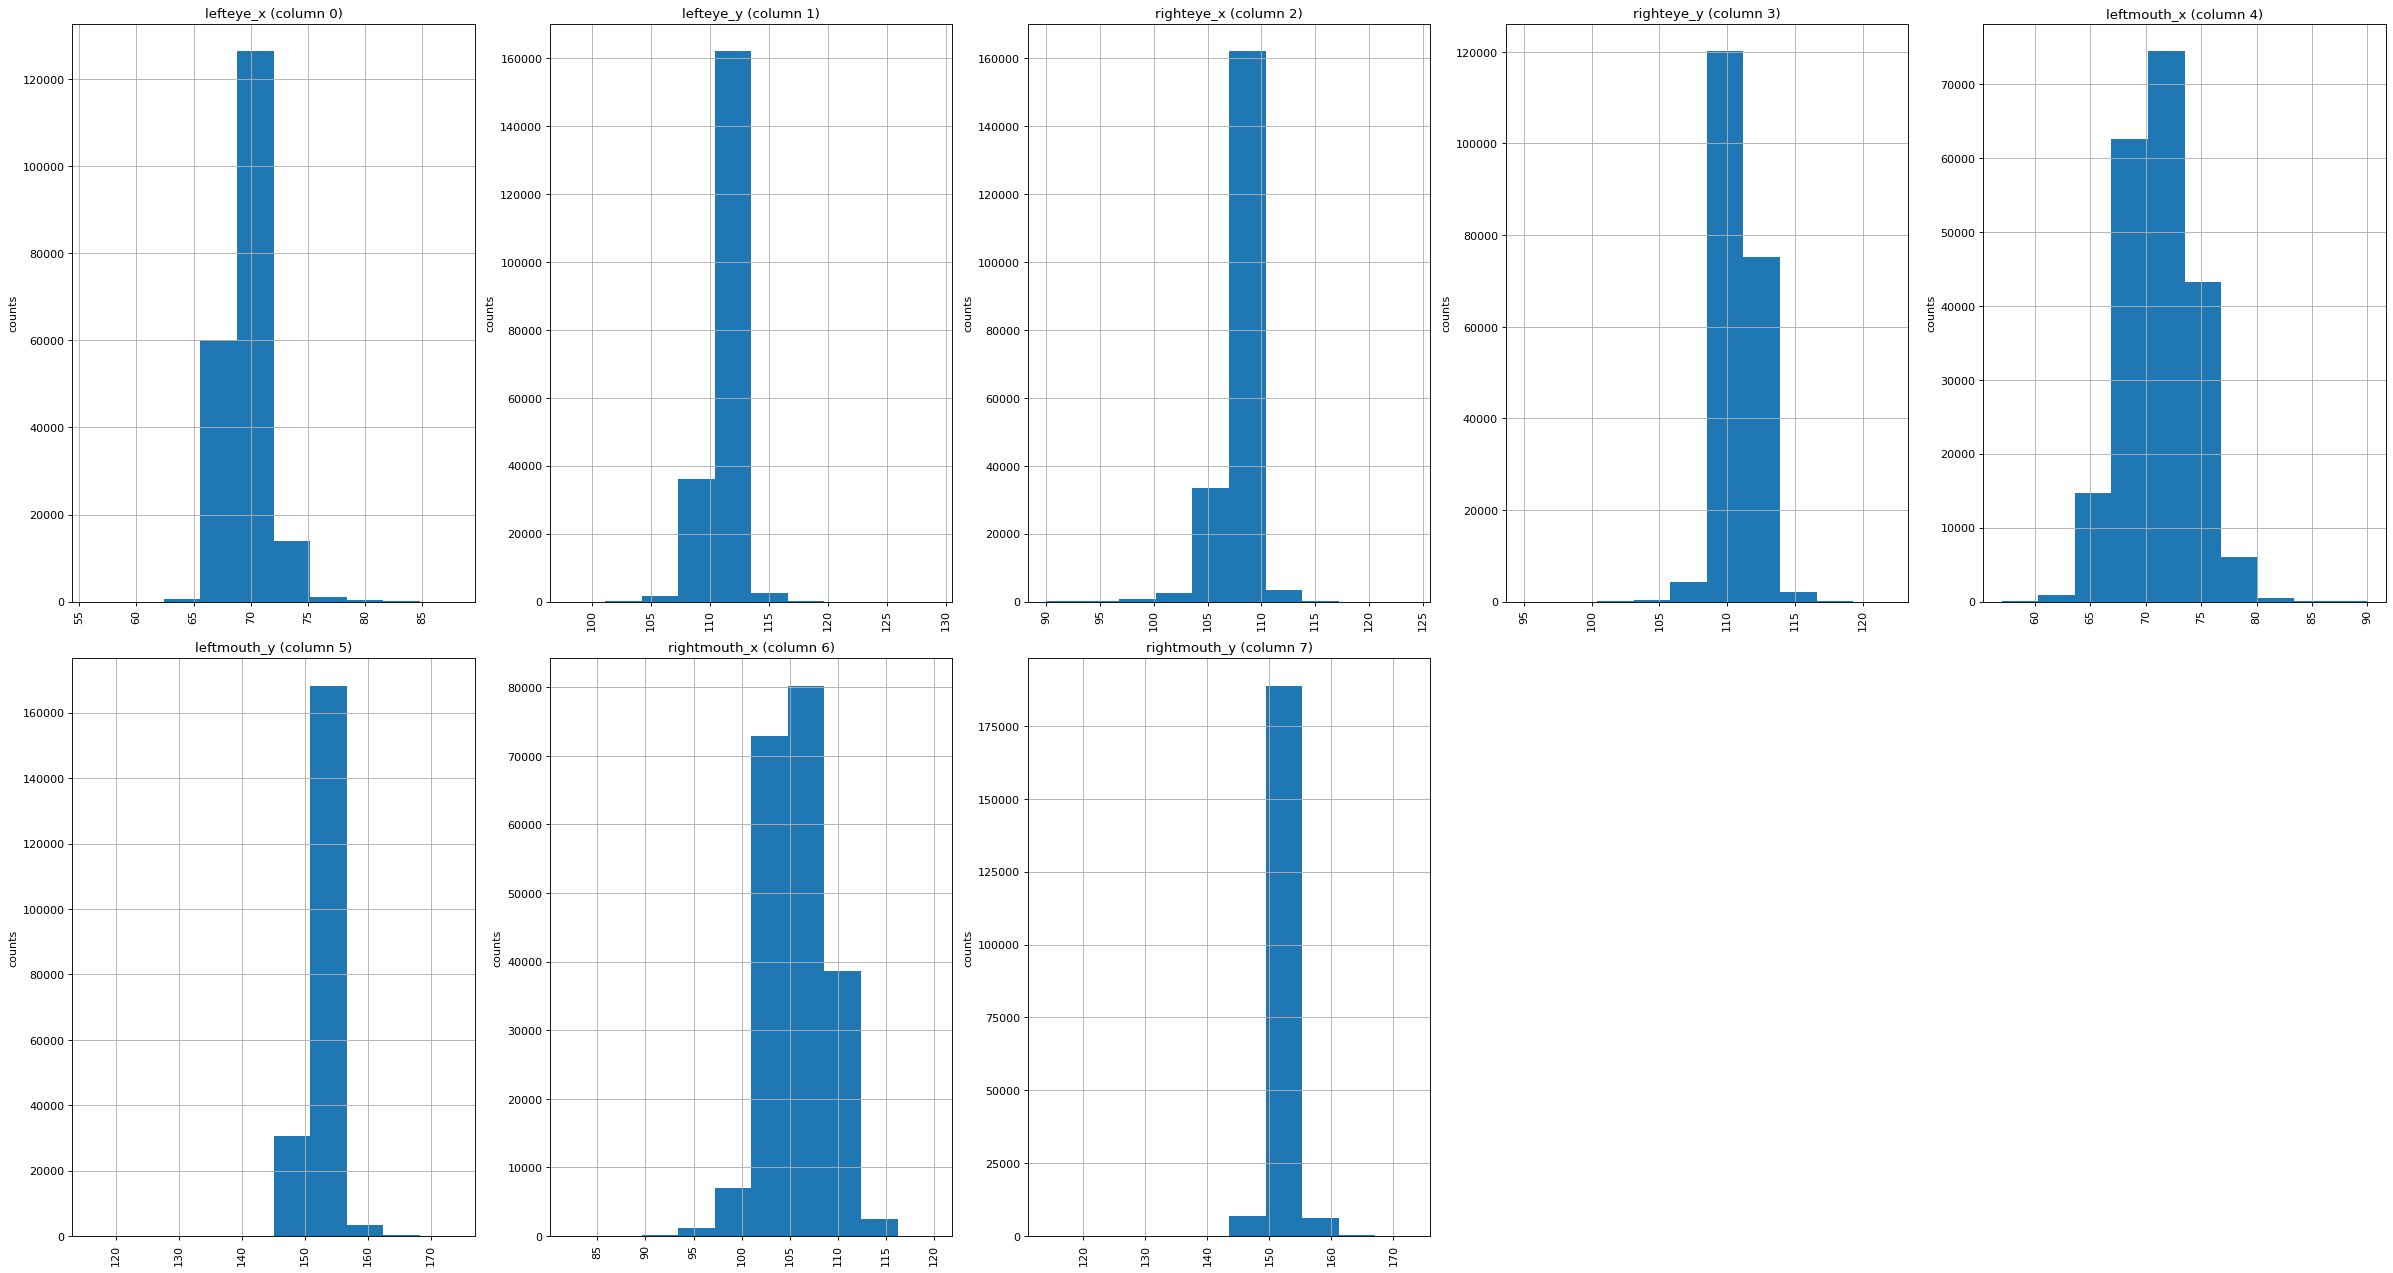

In [ ]:
plotPerColumnDistribution(df_landmarks, 10, 5)

# Creazione dei Data Frame


In [ ]:
train_samples = 10000
val_samples = 2000
test_samples = 2000

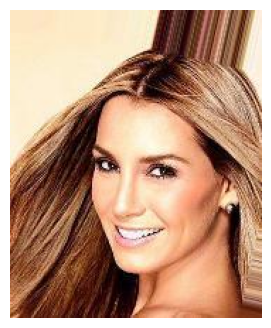

Smiling    1
Male       0
Young      1
Name: 000001.jpg, dtype: int64


In [ ]:
example_img = '/content/drive/Shareddrives/ProgettoSE4AI/dataset/img_align_celeba/000001.jpg'
img = Image.open(example_img)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.show()
attrs = df_attr.loc['000001.jpg', ['Smiling','Male','Young']]
print(attrs)

In [ ]:
img_dir = data_dir + 'img_align_celeba'

In [ ]:
# Extract filenames and labels
filenames = df_attr.iloc[:, 0].values  # First column contains filenames
labels = df_attr['Male'].values  # Extract only the "Male" column


# Load dataset split CSV
split_filenames = df_list_partition.iloc[:, 0].values  # First column contains filenames
split_labels = df_list_partition.iloc[:, 1].values  # Second column contains split indicators (0, 1, 2)

# Ensure both CSVs have matching filenames
filename_to_label = dict(zip(filenames, labels))  # Map filename to label

# Initialize lists for each split
train_paths, val_paths, test_paths = [], [], []
train_labels, val_labels, test_labels = [], [], []

# Assign images to respective sets
for fname, split_label in zip(split_filenames, split_labels):
    full_path = os.path.join(img_dir, fname)
    if fname in filename_to_label:  # Ensure file exists in attribute dictionary
        if split_label == 0:
            train_paths.append(full_path)
            train_labels.append(filename_to_label[fname])
        elif split_label == 1:
            val_paths.append(full_path)
            val_labels.append(filename_to_label[fname])
        elif split_label == 2:
            test_paths.append(full_path)
            test_labels.append(filename_to_label[fname])

# Convert lists to NumPy arrays
y_train = np.array(train_labels, dtype=np.float32)
y_val = np.array(val_labels, dtype=np.float32)
y_test = np.array(test_labels, dtype=np.float32)

In [ ]:
print("Esempi da df_attr:", filenames[:5])
print("Esempi da df_list_partition:", split_filenames[:5])

print("Intersezione:", len(set(filenames) & set(split_filenames)))


Esempi da df_attr: [0 0 0 0 0]
Esempi da df_list_partition: ['000001.jpg' '000002.jpg' '000003.jpg' '000004.jpg' '000005.jpg']
Intersezione: 0


In [ ]:
print(f'N train: {len(train_paths)}')
print(f'N validation: {len(val_paths)}')
print(f'N test: {len(test_paths)}')

N train: 0
N validation: 0
N test: 0


In [ ]:
# Function to load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (218, 178))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# Function to create a dataset
def create_dataset(image_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)  # Efficient loading
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))  # Shuffle dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Batch and prefetch
    return dataset

In [ ]:
# Create datasets
batch_size = 32
train_dataset = create_dataset(train_paths, y_train, batch_size=batch_size, shuffle=False)
val_dataset = create_dataset(val_paths, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(test_paths, y_test, batch_size=batch_size, shuffle=False)

TypeError: in user code:

    File "<ipython-input-29-ce357726ecef>", line 3, in load_image  *
        image = tf.io.read_file(image_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


# Altro

Creazione del DataFrame degli attributi delle immagini

In [ ]:
def decode_h5_strings(h5_file, ref_array):
    """
    It takes an array of object-reference (shape (N,1)) and
    returns the list of decoded strings.
    """
    strs = []
    for r in ref_array:
        # r è un array di lunghezza 1 contenente la reference
        ref = r[0]
        ds = h5_file[ref]           # dataset che contiene uint16 dei codici dei caratteri
        codes = ds[:].flatten()     # vettore di uint16
        s = ''.join(chr(c) for c in codes)
        strs.append(s)
    return strs

with h5py.File(attr_path, 'r') as f:
    # 1) decodifica i nomi dei file
    raw_names = f['name']          # shape (13143,1), dtype=object (HDF5 references)
    names = decode_h5_strings(f, raw_names)
    # sostituisci "\" con "/"
    names = [n.replace('\\', '/') for n in names]

    # 2) decodifica i nomi degli attributi
    raw_attrs = f['AttrName']      # shape (73,1)
    attrs = decode_h5_strings(f, raw_attrs)

    # 3) leggi la matrice delle etichette
    labels = f['label'][:]         # shape (73, 13143)

# 4) costruisci il DataFrame con dimensioni (13143 × 73)
df_label = pd.DataFrame(labels.T, index=names, columns=attrs)

df_label

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Eckhart/Aaron_Eckhart_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aaron_Guiel/Aaron_Guiel_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aaron_Patterson/Aaron_Patterson_0001.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Aaron_Peirsol/Aaron_Peirsol_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
Aaron_Peirsol/Aaron_Peirsol_0002.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zorica_Radovic/Zorica_Radovic_0001.jpg,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Zulfiqar_Ahmed/Zulfiqar_Ahmed_0001.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Zumrati_Juma/Zumrati_Juma_0001.jpg,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


from matplotlib import pyplot as plt
df_label['Male'].plot(kind='hist', bins=20, title='Male')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label['Asian'].plot(kind='hist', bins=20, title='Asian')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label['White'].plot(kind='hist', bins=20, title='White')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label['Black'].plot(kind='hist', bins=20, title='Black')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label.plot(kind='scatter', x='Male', y='Asian', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label.plot(kind='scatter', x='Asian', y='White', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label.plot(kind='scatter', x='White', y='Black', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label.plot(kind='scatter', x='Black', y='Baby', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_label['Male'].plot(kind='line', figsize=(8, 4), title='Male')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_label['Asian'].plot(kind='line', figsize=(8, 4), title='Asian')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_label['White'].plot(kind='line', figsize=(8, 4), title='White')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_label['Black'].plot(kind='line', figsize=(8, 4), title='Black')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
def load_image_file(file, mode='RGB'):
    """
    Loads an image file (.jpg, .png, etc) into a numpy array

    :param file: image file name or file object to load
    :param mode: format to convert the image to. Only 'RGB' (8-bit RGB, 3 channels) and 'L' (black and white) are supported.
    :return: image contents as numpy array
    """
    im = PIL.Image.open(file)
    if mode:
        im = im.convert(mode)
    return np.array(im)

In [ ]:
feature_vecs = []
fnames = []
for fname in tqdm(df_label.index):
    img_path = os.path.join(img_dir, fname)
    X_img = load_image_file(img_path)  # carica come array
    img = PIL.Image.fromarray(X_img)       # converte in oggetto PIL.Image
    img = img.resize((128, 128))       # ridimensiona
    img_array = np.array(img, dtype=np.uint8).flatten()  # torna a NumPy e appiattisci

    feature_vecs.append(img_array)
    fnames.append(fname)

df_feat = pd.DataFrame(feature_vecs, index=fnames)
df_label = df_label[df_label.index.isin(df_feat.index)]
df_feat.sort_index(inplace=True)
df_label.sort_index(inplace=True)

feature_path = os.path.join(data_dir, 'feature.csv')
labels_path = os.path.join(data_dir, 'label.csv')
df_feat.to_csv(feature_path)
df_label.to_csv(labels_path)

100%|██████████| 13143/13143 [01:20<00:00, 162.96it/s]


In [ ]:
attrs

['Male',
 'Asian',
 'White',
 'Black',
 'Baby',
 'Child',
 'Youth',
 'Middle Aged',
 'Senior',
 'Black Hair',
 'Blond Hair',
 'Brown Hair',
 'Bald',
 'No Eyewear',
 'Eyeglasses',
 'Sunglasses',
 'Mustache',
 'Smiling',
 'Frowning',
 'Chubby',
 'Blurry',
 'Harsh Lighting',
 'Flash',
 'Soft Lighting',
 'Outdoor',
 'Curly Hair',
 'Wavy Hair',
 'Straight Hair',
 'Receding Hairline',
 'Bangs',
 'Sideburns',
 'Fully Visible Forehead',
 'Partially Visible Forehead',
 'Obstructed Forehead',
 'Bushy Eyebrows',
 'Arched Eyebrows',
 'Narrow Eyes',
 'Eyes Open',
 'Big Nose',
 'Pointy Nose',
 'Big Lips',
 'Mouth Closed',
 'Mouth Slightly Open',
 'Mouth Wide Open',
 'Teeth Not Visible',
 'No Beard',
 'Goatee',
 'Round Jaw',
 'Double Chin',
 'Wearing Hat',
 'Oval Face',
 'Square Face',
 'Round Face',
 'Color Photo',
 'Posed Photo',
 'Attractive Man',
 'Attractive Woman',
 'Indian',
 'Gray Hair',
 'Bags Under Eyes',
 'Heavy Makeup',
 'Rosy Cheeks',
 'Shiny Skin',
 'Pale Skin',
 '5 o Clock Shadow',
 'S

In [ ]:
import matplotlib.pyplot as plt

# Seleziona le colonne di interesse
columns_of_interest = ['Male', 'Baby', 'Middle Aged','Senior', 'Young', 'Child']

# Somma i valori in ogni colonna (ogni 1 rappresenta un'osservazione)
counts = df_label[columns_of_interest].sum()

# Crea un grafico a barre
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color='skyblue')
plt.title('Numero di elementi per etnia')
plt.ylabel('Conteggio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


KeyError: "['Young'] not in index"

In [ ]:
# prompt: Controlla che in df_label ['Baby', 'Middle Aged','Senior', 'Young', 'Child'] abbiano la somma ad 1, ritorna il numero di elementi errati

# Seleziona le colonne di interesse
columns_of_interest = ['Baby', 'Middle Aged', 'Senior', 'Young', 'Child']

# Calcola la somma per ogni riga delle colonne di interesse
row_sums = df_label[columns_of_interest].sum(axis=1)

# Conta il numero di righe dove la somma non è uguale a 1
error_count = (row_sums != 1).sum()

print(f"Numero di elementi errati: {error_count}")


In [ ]:
# prompt: controlla che in df_label ['White', 'Black'] quanti elementi hanno entrambi 1

# Filtra il DataFrame per le righe dove sia 'White' che 'Black' sono uguali a 1
filtered_df = df_label[(df_label['White'] == 1) & (df_label['Black'] == 1)]

# Conta il numero di righe nel DataFrame filtrato
count = len(filtered_df)

print(f"Numero di elementi con 'White' e 'Black' entrambi uguali a 1: {count}")
filtered_df

Numero di elementi con 'White' e 'Black' entrambi uguali a 1: 9779


,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Eckhart/Aaron_Eckhart_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aaron_Guiel/Aaron_Guiel_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Aaron_Peirsol/Aaron_Peirsol_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
Aaron_Peirsol/Aaron_Peirsol_0002.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Aaron_Peirsol/Aaron_Peirsol_0003.jpg,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoran_Djindjic/Zoran_Djindjic_0002.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
Zoran_Djindjic/Zoran_Djindjic_0003.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
Zoran_Djindjic/Zoran_Djindjic_0004.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [ ]:
sum(counts)

11700.0

Salvataggio delle immagini e degli attributi in csv